In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import eurostat # A library for Eurostat data retrieval
import easygui # A library for creating simple GUIs

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
import xgboost as xgb   #machine learning model based on random forest algorithm
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sktime.performance_metrics.forecasting import MeanAbsolutePercentageError,MeanSquaredPercentageError 


from sklearn.base import BaseEstimator, TransformerMixin # Import classes for custom transformers
from sklearn.pipeline import Pipeline # Import the Pipeline class for data preprocessing

color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

### Country selection

In [2]:
# Define a dictionary mapping country names to their abbreviations
country_abbr = { 'Austria' : 'AT',
                 'Belgium' : 'BE',
                 'Bulgaria' : 'BG',
                 'Croatia' : 'HR',
                 'Denmark' : 'DK',
                 'Estonia' : 'ES',
                 'Finland' : 'FI',
                 'France' : 'FR',
                 'Germany' : 'DE',
                 'Greece' : 'EL',
                 'Hungary' : 'HU',
                 'Ireland' : 'IE',
                 'Italy' : 'IT',
                 'Latvia' : 'LV',
                 'Lithuania' : 'LT',
                 'Luxembourg' : 'LU',
                 'Malta' : 'MT',
                 'Netherlands' : 'NL',
                 'Norway' : 'NO',
                 'Poland' : 'PL',
                 'Portugal' : 'PT',
                 'Romania' : 'RO',
                 'Slovakia' : 'SK',
                 'Slovenia' : 'SI',
                 'Spain' : 'ES',
                 'Sweden' : 'SE',
                 'Türkiye' : 'TR'}

# Create a list of country names from the keys of the dictionary
eu_countries = list(country_abbr.keys())

# Show a graphical input window for the user to select a country from the list
eu_selection = easygui.choicebox("Please select a country.", "Country selection", eu_countries)

# Output the selected option or display an error message if no option is selected
if eu_selection:
    eu_abbr = country_abbr.get(eu_selection) # Get the abbreviation corresponding to the selected country.
    easygui.msgbox(f"You have selected '{eu_selection}'.", "Selection made")
else:
    easygui.msgbox("Please select a country!", "Error")
      
print(eu_abbr)

DE


### Food category selection + Query the prices of the selected food category
* source: https://ec.europa.eu/eurostat/databrowser/view/prc_fsc_idx/default/table?lang=en
* depending on the selected country

#### Food category selection

In [3]:
# Define a dictionary mapping food categories to their abbreviations
food_abbr = { 'Food' : 'CP011',
              'Bread': 'CP01113',
              'Meat' : 'CP0112',
              'Fish and seafood' : 'CP0113',
              'Milk, cheese and eggs' : 'CP0114',
              'Fruit' : 'CP0116',
              'Vegetables' : 'CP0117',
              'Potatoes' : 'CP01174',
              'Beer' : 'CP0213'}

# Create a list of food categories from the keys of the dictionary
food_prices = list(food_abbr.keys())

# Show a graphical input window for the user to select a food category from the list
food_selection = easygui.choicebox('Please select a food category.', 'Food category selection', food_prices)

# Output the selected option or display an error message if no option is selected
if food_selection:
    fp_abbr = food_abbr.get(food_selection) # Get the abbreviation corresponding to the selected food category.
    easygui.msgbox(f"You have selected '{food_selection}'.", "Selection made")
else:
    easygui.msgbox("Please select a food category!", "Error")

print(fp_abbr)

CP011


#### Query the prices of the selected food category

In [4]:
# Define the code for the Eurostat dataset
code_fp = 'PRC_HICP_MIDX'

# Query the parameters associated with the given code
pars_fp = eurostat.get_pars(code_fp) 
print(pars_fp)

# Define a filter to select specific data and retrieve the data from Eurostat based on the code and filter parameters
my_filter_pars_fp = {'startPeriod' : 1996, 'geo' : [eu_abbr], 'coicop' : [fp_abbr], 'unit' : 'I15'}
fp = eurostat.get_data_df(code_fp, filter_pars = my_filter_pars_fp)

# Adjustment of the data frame
fp = fp.drop(['freq', 'unit', 'coicop', 'geo\TIME_PERIOD'], axis=1) # Drop columns
fp = fp.melt(var_name='Date', value_name= fp_abbr) # Reshape the DataFrame by melting it to have a 'Date' column and a 'Food Price (€)' column

# Check and replace column names
fp.columns.name = None  # Clear the column names' name attribute

# Iterate through the columns and replace names based on a dictionary
for col in fp.columns:
    if col in food_abbr.values():
        key = [k for k, v in food_abbr.items() if v == col][0]
        new_col_name_fp = key + ' Price (€)'
        fp.rename(columns={col: new_col_name_fp}, inplace=True)
        
fp.head()

['freq', 'unit', 'coicop', 'geo']


,Date,Food Price (€)
0,1996-01,74.9
1,1996-02,75.5
2,1996-03,76.1
3,1996-04,76.4
4,1996-05,76.2


### Query the electricity prices (depending on the selected country)
* source: https://ec.europa.eu/eurostat/databrowser/view/NRG_PC_205/default/table?lang=en&category=nrg.nrg_price.nrg_pc
* The data is differentiated according to consumption. For the sake of simplicity, the average was taken here.

In [5]:
# Define the code for the Eurostat dataset
code_ep = 'NRG_PC_205'

# Query the parameters associated with the given code
pars_ep = eurostat.get_pars(code_ep)
print(pars_ep)

# Define a filter to select specific data and retrieve the data from Eurostat based on the code and filter parameters
my_filter_pars_ep = {'startPeriod' : 2007, 'geo' : [eu_abbr], 'tax' : 'X_TAX', 'nrg_cons' : ['MWH_LT20', 'MWH20-499', 
                                                                    'MWH500-1999', 'MWH2000-19999', 
                                                                    'MWH20000-69999', 'MWH70000-149999', 
                                                                    'MWH_GE150000' ], 'currency' : 'EUR' }
ep = eurostat.get_data_df(code_ep, filter_pars = my_filter_pars_ep)

# Adjustment of the data frame
ep = ep.drop(['freq', 'product', 'unit', 'tax', 'currency', 'nrg_cons', 'geo\TIME_PERIOD'], axis=1) # Drop columns
average = ep.mean(skipna=True).to_frame().T # Calculate the average over each column and ignore NaN values
ep = pd.concat([ep, average], axis=0) # Append the average row to the DataFrame
ep = ep.reset_index()
ep = ep.drop('index', axis=1)
ep = ep.drop(index=range(7)) # Drop all rows except for the average row
ep = ep.reset_index()
ep = ep.drop('index', axis=1)
ep = ep.melt(var_name='Date', value_name='€/kWh') # Reshape the DataFrame by melting it to have a 'Date' column and a '€/kWh' column

ep.head()

['freq', 'product', 'nrg_cons', 'unit', 'tax', 'currency', 'geo']


,Date,€/kWh
0,2007-S1,0.092300
1,2007-S2,0.094817
2,2008-S1,0.099583
3,2008-S2,0.100967
4,2009-S1,0.102817


#### Comment
* Insert the list "time_values" manually for further processing, as the original approach did not work.
* Since the data were only available on a semi-annual basis, they need to be expanded.

In [6]:
# Extend the data by repeating each row in the DataFrame 6 times
ep = ep.loc[np.repeat(ep.index, 6)].reset_index(drop=True)

# Define the list of time values
time_values = [
    '2007-01', '2007-02', '2007-03', '2007-04', '2007-05', '2007-06', '2007-07', '2007-08', '2007-09', '2007-10',
    '2007-11', '2007-12', '2008-01', '2008-02', '2008-03', '2008-04', '2008-05', '2008-06', '2008-07', '2008-08',
    '2008-09', '2008-10', '2008-11', '2008-12', '2009-01', '2009-02', '2009-03', '2009-04', '2009-05', '2009-06',
    '2009-07', '2009-08', '2009-09', '2009-10', '2009-11', '2009-12', '2010-01', '2010-02', '2010-03', '2010-04',
    '2010-05', '2010-06', '2010-07', '2010-08', '2010-09', '2010-10', '2010-11', '2010-12', '2011-01', '2011-02',
    '2011-03', '2011-04', '2011-05', '2011-06', '2011-07', '2011-08', '2011-09', '2011-10', '2011-11', '2011-12',
    '2012-01', '2012-02', '2012-03', '2012-04', '2012-05', '2012-06', '2012-07', '2012-08', '2012-09', '2012-10',
    '2012-11', '2012-12', '2013-01', '2013-02', '2013-03', '2013-04', '2013-05', '2013-06', '2013-07', '2013-08',
    '2013-09', '2013-10', '2013-11', '2013-12', '2014-01', '2014-02', '2014-03', '2014-04', '2014-05', '2014-06',
    '2014-07', '2014-08', '2014-09', '2014-10', '2014-11', '2014-12', '2015-01', '2015-02', '2015-03', '2015-04',
    '2015-05', '2015-06', '2015-07', '2015-08', '2015-09', '2015-10', '2015-11', '2015-12', '2016-01', '2016-02',
    '2016-03', '2016-04', '2016-05', '2016-06', '2016-07', '2016-08', '2016-09', '2016-10', '2016-11', '2016-12',
    '2017-01', '2017-02', '2017-03', '2017-04', '2017-05', '2017-06', '2017-07', '2017-08', '2017-09', '2017-10',
    '2017-11', '2017-12', '2018-01', '2018-02', '2018-03', '2018-04', '2018-05', '2018-06', '2018-07', '2018-08',
    '2018-09', '2018-10', '2018-11', '2018-12', '2019-01', '2019-02', '2019-03', '2019-04', '2019-05', '2019-06',
    '2019-07', '2019-08', '2019-09', '2019-10', '2019-11', '2019-12', '2020-01', '2020-02', '2020-03', '2020-04',
    '2020-05', '2020-06', '2020-07', '2020-08', '2020-09', '2020-10', '2020-11', '2020-12', '2021-01', '2021-02',
    '2021-03', '2021-04', '2021-05', '2021-06', '2021-07', '2021-08', '2021-09', '2021-10', '2021-11', '2021-12',
    '2022-01', '2022-02', '2022-03', '2022-04', '2022-05', '2022-06', '2022-07', '2022-08', '2022-09', '2022-10',
    '2022-11', '2022-12']

ti = pd.DataFrame({'Time':time_values}) # Create a DataFrame 'ti' with the 'Time' column containing time_values
ep1 = ep.merge(ti, left_on='Date', right_on='Time') # Merge the 'ep' DataFrame with the 'ti' DataFrame using the 'Date' and 'Time' columns

# Fill missing values in the 'Time' and '€/kWh' columns using corresponding values from 'ti' and 'ep'
ep1['Time'] = ti['Time'].fillna(ep1['Time'])
ep1['€/kWh'] = ep['€/kWh'].fillna(ep1['€/kWh'])

# Adjustment of the data frame
ep = ep1.drop('Date', axis=1)
ep.rename(columns={'Time': 'Date'}, inplace=True)
new_columns_order = ['Date', '€/kWh']
ep = ep[new_columns_order]

ep.head()

,Date,€/kWh
0,2007-01,0.0923
1,2007-02,0.0923
2,2007-03,0.0923
3,2007-04,0.0923
4,2007-05,0.0923


### Query the exchange rate
* source: https://ec.europa.eu/eurostat/databrowser/view/ert_bil_eur_m/default/table?lang=en
* Euro/ECU to US-Dollar

In [7]:
# Define the code for the Eurostat dataset
code_exp = 'ERT_BIL_EUR_M'

# Query the parameters associated with the given code
pars_ex = eurostat.get_pars(code_exp)
print(pars_ex)

# Define a filter to select specific data and retrieve the data from Eurostat based on the code and filter parameters
my_filter_pars_exp = {'startPeriod' : 1996, 'currency' : 'USD', 'statinfo' : 'AVG'}
exp = eurostat.get_data_df(code_exp, filter_pars = my_filter_pars_exp)

# Adjustment of the data frame
exp = exp.drop(['freq','statinfo','unit','currency\TIME_PERIOD'], axis=1) # Drop columns
exp = exp.melt(var_name='Date', value_name='Exchange Rate ($/€)') # Reshape the DataFrame by melting it to have a 'Date' column and a 'Food Price (€)' column

exp.head()

['freq', 'statinfo', 'unit', 'currency']


,Date,Exchange Rate ($/€)
0,1996-01,1.2918
1,1996-02,1.2886
2,1996-03,1.2813
3,1996-04,1.2639
4,1996-05,1.2467


### Query the Brent Oil Price
* source: https://de.investing.com/commodities/brent-oil-historical-data

In [8]:
# Read the data
bop = pd.read_csv('Oil_price/Brent.csv', sep=";", header=0)

# Adjustment of the data frame
bop = bop.drop(bop.columns[2:7], axis=1) # Drop columns
bop.rename(columns={'Datum': 'Date'}, inplace=True) # Change the Name
bop.rename(columns={'Zuletzt': 'Oil Price (USD per gallon)'}, inplace=True) # Change the Name

# Apply a lambda function to replace ',' with '.' in all columns of the DataFrame 'bop'
bop = bop.apply(lambda x: x.str.replace(',','.'))
bop['Oil Price (USD per gallon)'] = bop['Oil Price (USD per gallon)'].astype(float) # Change dtype

bop.head()

,Date,Oil Price (USD per gallon)
0,1996-01,16.52
1,1996-02,17.76
2,1996-03,19.41
3,1996-04,19.02
4,1996-05,17.80


### Pipeline for the weather data (temperature and precipitation) - only Germany

#### Import the data

In [9]:
# List of month names
months = ["January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"]

# Loading the data 
temp_data = []
pre_data = []

# Loop through the list of month names
for month_name in months:
    temp_filename = f'Weather_data/Temperature/{month_name}.txt' # source: https://opendata.dwd.de/climate_environment/CDC/regional_averages_DE/monthly/air_temperature_mean/
    pre_filename = f'Weather_data/Precipitation/{month_name}.txt' # source: https://opendata.dwd.de/climate_environment/CDC/regional_averages_DE/monthly/precipitation/
    
    try:
        # Attempt to read the temperature and precipitation data from the respective files
        temp_df = pd.read_csv(temp_filename, sep=";", header=1)
        pre_df = pd.read_csv(pre_filename, sep=";", header=1)
        
        # Append the loaded dataframes to the respective lists
        temp_data.append(temp_df)
        pre_data.append(pre_df)
        
    except FileNotFoundError:
        # If the file for a specific month is not found, print a message
        print(f'File for {month_name} not found.')

#### Preprocessing Pipeline:

* Drop data before 1996
* Create a new column consisting of the year and month (format: YYYY-MM)
* Rename the Column "Deutschland" to "Temperature (°C)" or to "Precipitation (l/m²)"
* Delete unnecassary columns
* Change the order

#### Setting up the estimators for the pipeline

In [10]:
# This class removes data rows where the year is less than 1996
class DataDropper(BaseEstimator, TransformerMixin):
    def __init__(self, min_year=1996):
        self.min_year = min_year

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[X["Jahr"] >= self.min_year].reset_index(drop=True)
    
    
# This class creates a new column "Date" by combining year and month 
class ColumnCreater(BaseEstimator, TransformerMixin):

    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        # Check if the "Date" column already exists, otherwise create it
        if "Date" not in X.columns:
            X["Date"] = ""
        # Loop through the rows of the DataFrame to create the "Date" column
        for index, row in X.iterrows():
            if row["Monat"] < 10:
                X.at[index, "Date"] = str(row["Jahr"]) + "-0" + str(row["Monat"])
            else:
                X.at[index, "Date"] = str(row["Jahr"]) + "-" + str(row["Monat"])    
        return X
  

# This class changes the column name "Germany"   
class ColumnRenamer(BaseEstimator, TransformerMixin):
    def __init__(self, old_name, new_name):
        self.old_name = old_name
        self.new_name = new_name

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X.rename(columns={self.old_name: self.new_name}, inplace=True)
        return X


# This class drops the first 18 columns of the DataFrame.
class ColumnDropper(BaseEstimator, TransformerMixin):

    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        # Drop the first 18 columns of the DataFrame
        columns_to_delete = list(range(0,18))
        return X.drop(X.columns[columns_to_delete], axis=1)
    

# This class changes the order of columns
class OrderChanger(BaseEstimator, TransformerMixin):
    def __init__(self, new_column_order):
        self.new_column_order = new_column_order

    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X[self.new_column_order]

#### Application of the pipeline

In [11]:
# Define the pipelines
tpipe = Pipeline([
    ("ddropper", DataDropper()),
    ("creater", ColumnCreater()),
    ("column_renamer", ColumnRenamer(old_name="Deutschland", new_name="Temperature (°C)")),
    ("cdropper", ColumnDropper()),
    ("ochanger", OrderChanger(new_column_order=["Date", "Temperature (°C)"]))
])

ppipe = Pipeline([
    ("ddropper", DataDropper()),
    ("creater", ColumnCreater()),
    ("column_renamer", ColumnRenamer(old_name="Deutschland", new_name="Precipitation (l/m²)")),
    ("cdropper", ColumnDropper()),
    ("ochanger", OrderChanger(new_column_order=["Date", "Precipitation (l/m²)"]))
])

# Applying the transformations in loops
for i in range(len(temp_data)):
    temp_data[i] = tpipe.fit_transform(temp_data[i])
    pre_data[i] = ppipe.fit_transform(pre_data[i])

# Merging the DataFrames in loops
list_temp = ["Date", "Temperature (°C)"]
list_precip = ["Date", "Precipitation (l/m²)"]

temp = temp_data[0]
pre = pre_data[0]

for i in range(1, len(temp_data)):
    temp = temp.merge(temp_data[i], on=list_temp, how="outer")
    pre = pre.merge(pre_data[i], on=list_precip, how="outer")

# Sorting the DataFrames
temp = temp.sort_values(by=["Date"], ignore_index=True)
pre = pre.sort_values(by=["Date"], ignore_index=True)

# Merging the DataFrames
wt = temp.merge(pre, on='Date', how="outer")

wt.head()

,Date,Temperature (°C),Precipitation (l/m²)
0,1996-01,-2.82,7.0
1,1996-02,-2.18,48.6
2,1996-03,1.00,23.3
3,1996-04,8.40,23.1
4,1996-05,11.15,91.4


### Option to add various producer prices
* source: https://ec.europa.eu/eurostat/databrowser/view/sts_inppd_m/default/table?lang=en

#### Producer price selection

In [12]:
# Define a dictionary mapping various producer prices to their abbreviations
producer_prices_abbr = {'Manufacture of food products' : 'C10',
                        'Manufacture of bakery and farinaceous products' : 'C107',
                        'Manufacture of other food products' : 'C108',
                        'Manufacture of prepared feeds for farm animals' : 'C1091',
                        'Manufacture of pesticides and other agrochemicals products' : 'C202',
                        'Manufacture of grain mill products, starches and starch products' : 'C106'}

# Create a list of producer prices from the keys of the dicitionary
producer_prices = list(producer_prices_abbr.keys())

# Show a graphical input window for the user to select a country from the list
pp_selection = easygui.multchoicebox('Please select the producer prices you are interested in.', ' ', producer_prices)

# Output the selected option or display an error message if no option is selected
if pp_selection:
    pp_abbr = [producer_prices_abbr[item] for item in pp_selection] # Get the abbreviation corresponding to the selected producer prices.
    easygui.msgbox(f"You have selected: {', '.join(pp_selection)}.")
else:
    pass # Do nothing if no options are selected

if 'pp_abbr' in locals():
    print(pp_abbr)

#### Query producer prices

In [13]:
if 'pp_abbr' in locals():
    
    # Define the code for Eurostat dataset
    code_pp = 'STS_INPPD_M'

    # Query the parameters associated with the given code
    pars_pp = eurostat.get_pars(code_pp)
    print(pars_pp)

    # Define a filter to select specific datas and retrive the data from Eurostat beased on the vopde and filter parameters
    my_filter_pars_pp = {'startPeriod' : 1996, 'geo' : [eu_abbr], 'nace_r2' : pp_abbr, 'unit' : 'I15'}
    pp = eurostat.get_data_df(code_pp, filter_pars = my_filter_pars_pp)

    # Adjustment of the data frame
    pp = pp.drop(['freq','indic_bt','s_adj','unit','geo\TIME_PERIOD'], axis=1)

    # Reshape the DataFrame using the `melt` function. This step is used to transform the wide format DataFrame into a long format
    pp = pp.melt(id_vars=['nace_r2'], var_name='Date', value_name='Wert')

    # Pivot the DataFrame to create columns for each unique value in 'nace_r2'. This step is used to transform the long format DataFrame back into a wide format
    pp = pp.pivot(index='Date', columns='nace_r2', values='Wert').reset_index()

    # Check and replace column names
    pp.columns.name = None  # Clear the column names' name attribute

    # Iterate through the columns and replace names based on a dictionary
    for col_pp in pp.columns:
        if col_pp in producer_prices_abbr.values():
            key = [k for k, v in producer_prices_abbr.items() if v == col_pp][0]
            new_col_name_pp = key + " (€)"
            pp.rename(columns={col_pp: new_col_name_pp}, inplace=True)

    pp.head()



### Merging all the data
* fp = Food Category Price Data
* bop = Brent Oil Price Data
* ep = Electricity Price Data
* exp = Exchange Rate Data
* wt = Weather Data
* pp = Producer Price

In [14]:
# Merge the four DataFrames ('fp', 'bop', 'ep', 'exp') on the 'Date' column using outer joins
df = fp.merge(bop, on='Date', how='outer')
df = df.merge(ep, on='Date', how='outer')
df = df.merge(exp, on='Date', how='outer')

# Check if the 'abbr' variable is equal to 'DE' (Germany)
if eu_abbr == 'DE':
    # If 'abbr' is 'DE', merge 'wt' DataFrame on the 'Date' column using an outer join
    df = df.merge(wt, on='Date', how='outer')

# Check if the 'pp' DataFrame exists and merge it if it does
if 'pp' in globals():
    df = df.merge(pp, on='Date', how='outer')

df = df.replace({None: np.nan})

df.head()

,Date,Food Price (€),Oil Price (USD per gallon),€/kWh,Exchange Rate ($/€),Temperature (°C),Precipitation (l/m²)
0,1996-01,74.9,16.52,NaN,1.2918,-2.82,7.0
1,1996-02,75.5,17.76,NaN,1.2886,-2.18,48.6
2,1996-03,76.1,19.41,NaN,1.2813,1.00,23.3
3,1996-04,76.4,19.02,NaN,1.2639,8.40,23.1
4,1996-05,76.2,17.80,NaN,1.2467,11.15,91.4


### Correlation diagram

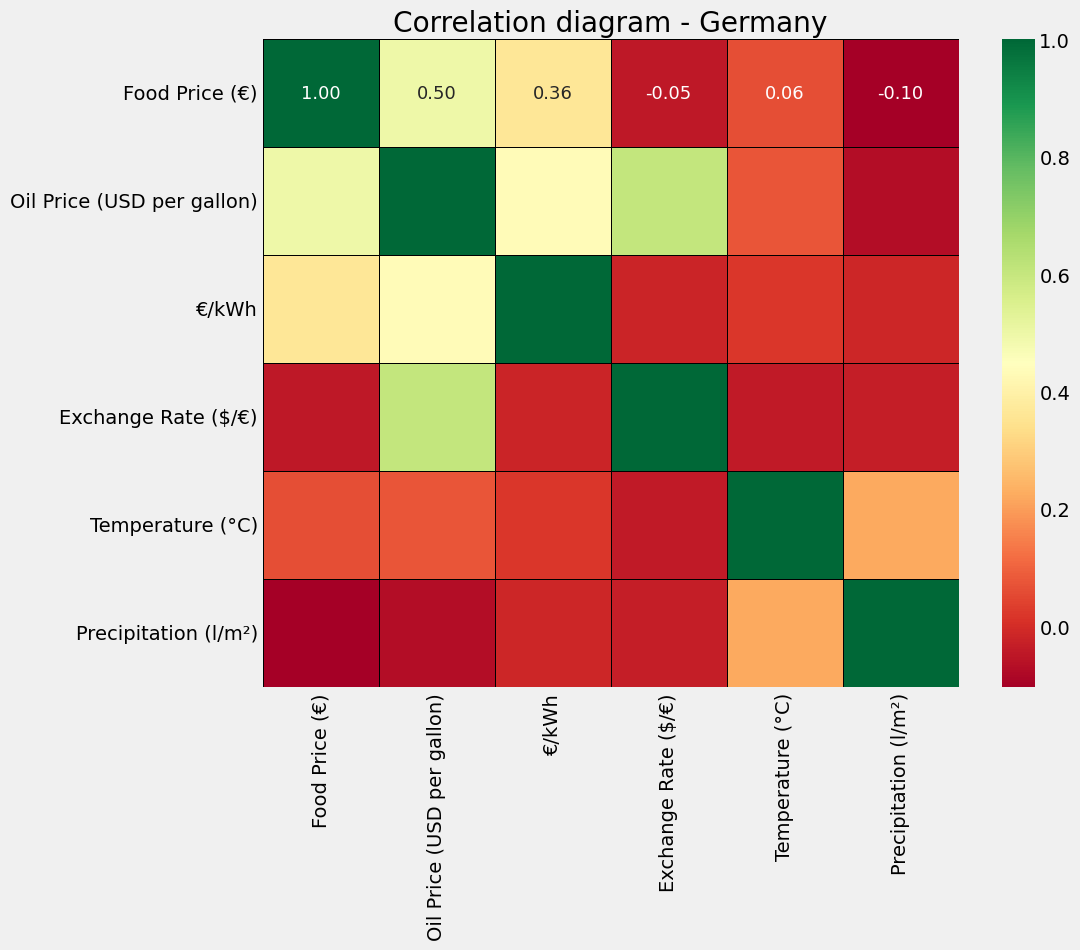

In [15]:
plt.figure(figsize=(10,8)) # Create a new figure (plot) with a specific size (10 inches width x 8 inches height)
sns.heatmap(df.corr(numeric_only = True), annot=True, cmap="RdYlGn", cbar=True, linecolor='black', linewidths=0.5, fmt=".2f", annot_kws={"size": 13} )
plt.title('Correlation diagram' + ' - ' + eu_selection) # Set the title for the chart. The title includes the selected country name.
plt.show()

### save dataframe with all variables as df_complete and use df as only having the foodprice values

In [45]:
df_complete = df
old_name = fp.columns[1]

#name column 'FoodPriceIndex' because that is the name in the later parts of the script
df = fp.rename(columns={old_name:'FoodPriceIndex'})

#check for missing values:
missing = np.where(df.isna())

#print message box if data is missing
a,b = np.shape(missing)
if b > 0:
    easygui.msgbox("There are missing values in the data.")

## Define Features of Pipeline

### Data preprocessing:
- convert Datetime
- drop post 21
- plot data before preprocessing
- show outliers
- remove outliers (removed values are getting linear interpolated, not sure if this is the best way to do it, todo)
- remove trend by taking the differences between the values
- set Cross Validation Split
- create Features

### to add in the future:
- option to choose between different ML models (XGBoost,sktime, LSTM...)
- option to activate grid search
- option to actually look into the future


In [46]:
class ConvertDateTime(BaseEstimator, TransformerMixin):

    def fit(self, X, y= None):
        return self
    
    def transform(self, X):
        X = X.set_index('Date')
        X.index = pd.to_datetime(X.index)
        return X

class DropPost21(BaseEstimator, TransformerMixin):
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X = X.loc[X.index < '2021-11']
        return X
    
class PlotPreData(BaseEstimator, TransformerMixin):
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X.plot(figsize=(15, 5),
        color=color_pal[0],
        title=  'Food price index for: ' + eu_selection+ ' - ' + food_selection )
        plt.show
        return X

class ShowOutliers(BaseEstimator, TransformerMixin):

    def __init__(self,min,max):
        self.min = min
        self.max = max

    def fit(self, X, y= None):
        return self
    
    def transform(self, X):
        print(self.min)
        print(self.max)
        X['FoodPriceIndex'].plot(kind='hist',bins=500)
        print(X.query(f'FoodPriceIndex < {self.min}'))
        print(X.query(f'FoodPriceIndex > {self.max}'))
        return X

class RemoveOutliers(BaseEstimator, TransformerMixin):

    def __init__(self,min,max):
        self.min = min
        self.max = max

    def fit(self, X, y= None):
        return self
    
    def transform(self, X):

        #this method leads to replacing the valus with NaN instead of deleting the row completely
        X = X[X > self.min]
        X = X[X < self.max]
        Nans = np.where(X.isna())

        #interpolate betweeen data points that are Nan
        X['FoodPriceIndex'] = X['FoodPriceIndex'].interpolate(method='linear')
        X['FoodPriceIndex'].plot(kind='hist',bins=500)

        return X
    

class AbsDiffData(BaseEstimator, TransformerMixin):
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X = X.diff()
        X = X.dropna()
        fig, ax = plt.subplots(figsize=(15,5))
        X.plot(ax=ax, label='Training Set', title='Difference between Data Points')
        ax.legend(['Training Set', 'Test Set'])
        plt.show()
        return X

class CrossValidationSplit(BaseEstimator, TransformerMixin):

    def __init__(self,split_info, show_plot):
        self.split_info = split_info
        self.show_plot = show_plot

    def fit(self, X, y=None):
        return self
    
    def transform(self, X):

        tss = self.split_info
        
        #sort dataset:
        X = X.sort_index()

        if self.show_plot:
            fig, axs = plt.subplots(tss.get_n_splits(), 1, figsize=(15,14), sharex=True)
        
        fold = 0

        #loop for aranging the split for the cross validation
        for train_idx, val_idx in tss.split(X):
            train = X.iloc[train_idx]
            test = X.iloc[val_idx]

            if self.show_plot:
                train['FoodPriceIndex'].plot(ax=axs[fold],label='Training Set',title=f'Data Train/Test Split Fold {fold}')
                test['FoodPriceIndex'].plot(ax=axs[fold],label='Test Set')
                axs[fold].axvline(test.index.min(), color='black', ls='--')
            fold += 1

        if self.show_plot: 
            plt.show()
        return X
    
class CreateFeatures(BaseEstimator, TransformerMixin):
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        
        #Create time series features based on time series index
        X = X.copy()
        X['Month'] = X.index.month
        X['Year'] = X.index.year
        X['Quarter'] = X.index.quarter

        return X

### Model Training:

In [47]:
class TrainModel(BaseEstimator, TransformerMixin):
    
    def __init__(self,split_info,split_time,use_cv,show_plot):
        self.split_info = split_info
        self.split_time = split_time
        self.show_plot = show_plot
        self.use_cv = use_cv

    def fit(self, X, y=None):
        return self
    
    def transform(self, X):

        tss = self.split_info
        
        if self.use_cv: 
            fold = 0
            preds = []
            scores = []
            not_added = True
            for train_idx, val_idx in tss.split(X):
                train = X.iloc[train_idx]
                test = X.iloc[val_idx]

                FEATURES = ['Month','Year','Quarter']
                TARGET = 'FoodPriceIndex'

                X_train = train[FEATURES]
                y_train = train[TARGET]

                X_test = test[FEATURES]
                y_test = test[TARGET]

                reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                                    n_estimators=1000,
                                    early_stopping_rounds=50,
                                    objective='reg:linear', 
                                    max_depth=3,
                                    learning_rate=0.01)
                reg.fit(X_train, y_train,
                        eval_set=[(X_train, y_train), (X_test, y_test)],
                        verbose=100)
                
                #save result of each fold to dataframe
                test['prediction'] = reg.predict(X_test)

                #save all predictions in one dataframe
                if not_added:
                    datasaver = test
                else:
                    datasaver = pd.concat([datasaver,test], ignore_index=False)
                not_added = False

                y_pred = reg.predict(X_test)
                preds.append(y_pred)
                score = np.sqrt(mean_squared_error(y_test, y_pred))
                scores.append(score)

            print(f'Score across folds (meansquarederror) {np.mean(scores):0.4f}')
            print(f'Fold scores:{scores}')
            
            X = X.merge(datasaver[['prediction']], how='left', left_index=True, right_index=True)

        #if use_cv is not active:     
        else:

            train = X.loc[X.index < self.split_time]
            test = X.loc[X.index >= self.split_time]

            FEATURES = ['Month','Year','Quarter']
            TARGET = 'FoodPriceIndex'

            X_train = train[FEATURES]
            y_train = train[TARGET]

            X_test = test[FEATURES]
            y_test = test[TARGET]

            reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',                        
                       n_estimators=1000,
                       early_stopping_rounds=50,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)
            reg.fit(X_train, y_train,                                                       
                        eval_set=[(X_train, y_train), (X_test, y_test)],
                        verbose=20)
            test['prediction'] = reg.predict(X_test)
            X = X.merge(test[['prediction']], how='left', left_index=True, right_index=True)
            

        if self.show_plot:
                ax = X[['FoodPriceIndex']].plot(figsize=(15, 5))
                X['prediction'].plot(ax=ax, style='-')
                plt.legend(['Truth Data', 'Predictions'])
                ax.set_title('Raw Dat and Prediction')
                plt.show()

        return X

### Postprocessing:

In [48]:
class ShowResults(BaseEstimator, TransformerMixin):
    
    def __init__(self,df_abs,start_time):
        self.df_abs = df_abs
        self.start_time = start_time

    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X_pred = X['prediction'].cumsum()
        X_train = self.df_abs.loc[self.df_abs.index < self.start_time]   
        last_value = X_train.iloc[-1,0]
        X_pred = X_pred.add(last_value)
        X_merged = self.df_abs.merge(X_pred, how='left', left_index=True, right_index=True)

        #plot
        ax = X_merged[['FoodPriceIndex']].plot(figsize=(15, 5))
        X_merged['prediction'].plot(ax=ax, style='-')
        plt.legend([f'Truth Data of {old_name} in {eu_selection}', 'Predictions'])
        ax.set_title('Raw Dat and Prediction')
        plt.show()

        mape = MeanAbsolutePercentageError(symmetric=False)
        mape.get_tag("lower_is_better")
        mspe = MeanSquaredPercentageError(symmetric=False)
        mspe.get_tag("lower_is_better")

        df_test_split = self.df_abs.loc[self.df_abs.index >= self.start_time]
        df_pred_split = X_pred.loc[X_pred.index >= self.start_time]

        res_mape = mape(df_test_split,df_pred_split)
        res_mspe = mspe(df_test_split,df_pred_split)

        return X_merged,res_mape,res_mspe

## Start the Pipeline:

### Config:


In [49]:
#configure all variables here:

#set lower and upper boundary for printing the outliers 
lower_than = -1
higher_than = 2.5

#use cross validation:
use_cv = False

#Plot the graph with the different splits for the cross validation
show_cv_split = False

#configure split for crossvalidation (number of splits, size (months*years), gap)
tss = TimeSeriesSplit(n_splits=5, test_size=12*3, gap = 1)  

#if use_cv = False, set start time of split like this start_time = '2015-01' or whatever 'year-month' you want to use
split_time = '2015-01'

### Pipeline

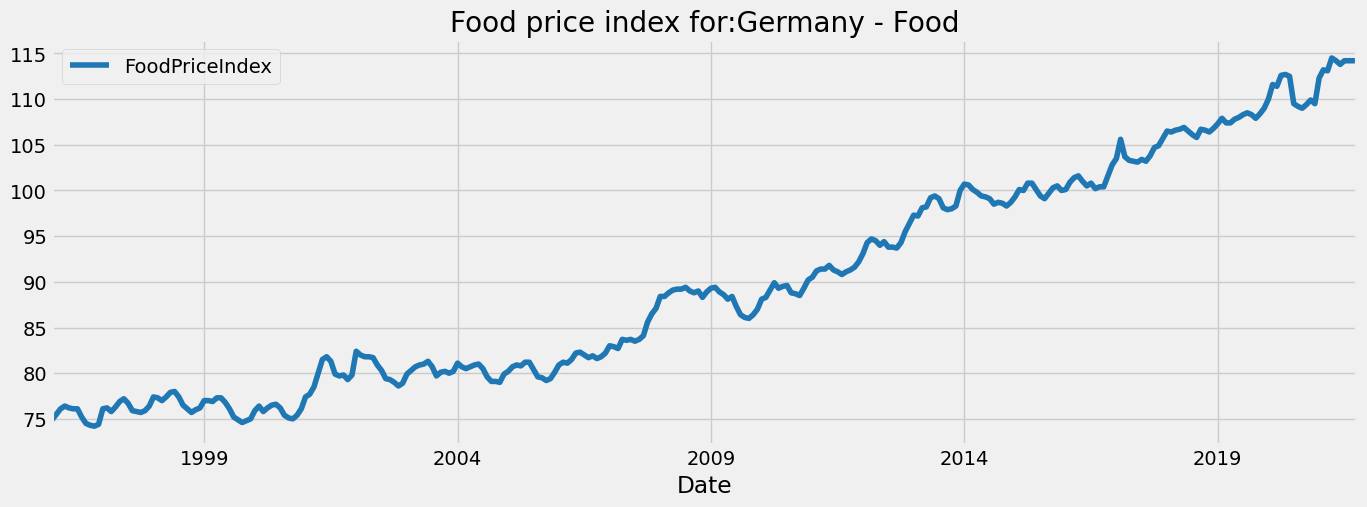

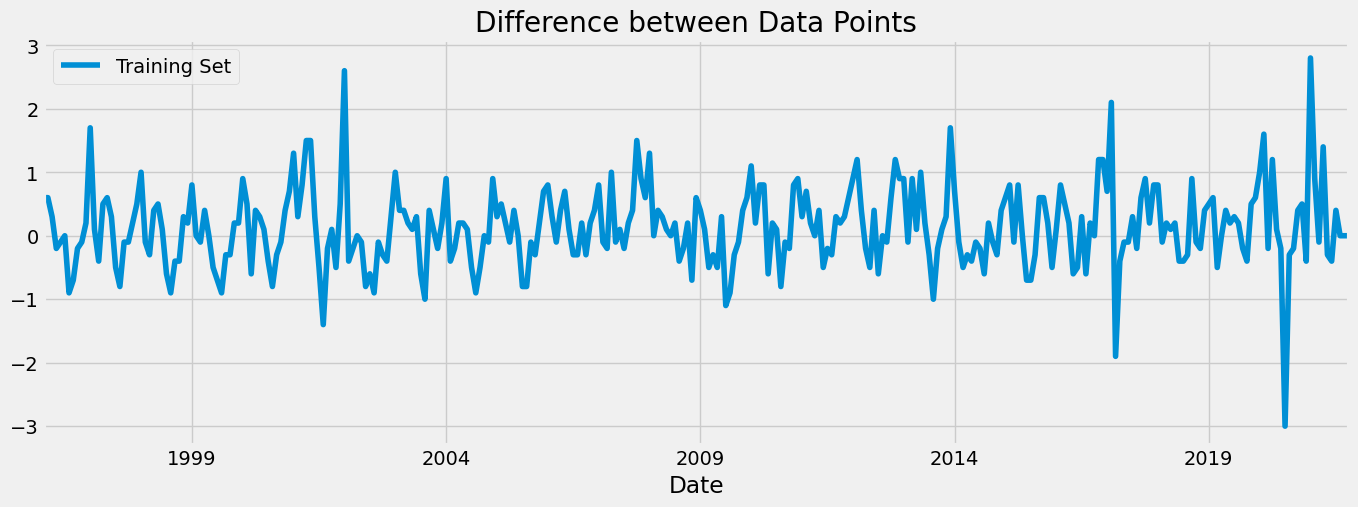

-1
2.5
            FoodPriceIndex
Date                      
2001-08-01            -1.4
2009-07-01            -1.1
2017-03-01            -1.9
2020-07-01            -3.0
            FoodPriceIndex
Date                      
2002-01-01             2.6
2021-01-01             2.8


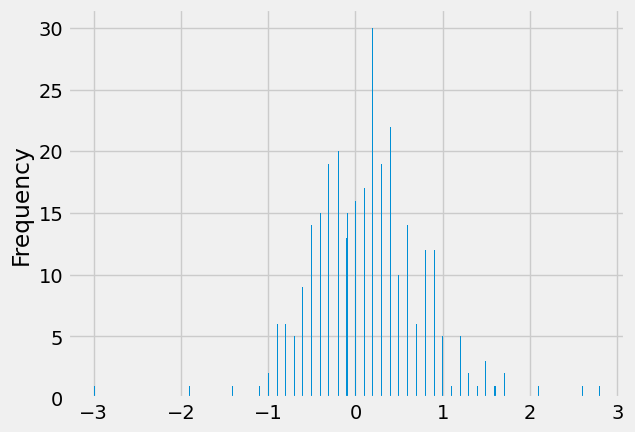

In [50]:
pipe0 = Pipeline([
    ("1", ConvertDateTime()),
    ("2", DropPost21()),
    ("3", PlotPreData())
])

df = pipe0.fit_transform(df)
df_abs = df             #store absolute values of data frame, for plotting later

pipe1 = Pipeline([
    ("4", AbsDiffData()),
    ("5", ShowOutliers(lower_than,higher_than))     #print values lower than (...,) and higher than (,...)
])

df = pipe1.fit_transform(df)

### Print splits and add features:

In [51]:
pipe3 =  Pipeline([
    #("6", RemoveOutliers(-1,2.5))       #remove values lower than(...,) and higher than (,...)
    ("7", CrossValidationSplit(tss,show_cv_split)),    
    ("8", CreateFeatures())
])

df = pipe3.fit_transform(df)

### do the Training:  

[0]	validation_0-rmse:0.69787	validation_1-rmse:0.81150
[20]	validation_0-rmse:0.62768	validation_1-rmse:0.77375
[40]	validation_0-rmse:0.57313	validation_1-rmse:0.74761


[60]	validation_0-rmse:0.52929	validation_1-rmse:0.72994
[80]	validation_0-rmse:0.49607	validation_1-rmse:0.71861
[100]	validation_0-rmse:0.46882	validation_1-rmse:0.70932
[120]	validation_0-rmse:0.44804	validation_1-rmse:0.70348
[140]	validation_0-rmse:0.43263	validation_1-rmse:0.70046
[160]	validation_0-rmse:0.42063	validation_1-rmse:0.69832
[180]	validation_0-rmse:0.41168	validation_1-rmse:0.69751
[200]	validation_0-rmse:0.40424	validation_1-rmse:0.69860
[220]	validation_0-rmse:0.39779	validation_1-rmse:0.70191
[224]	validation_0-rmse:0.39656	validation_1-rmse:0.70283


c:\Users\Jakob\Documents\git\Food-price-forecast\venv\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
c:\Users\Jakob\Documents\git\Food-price-forecast\venv\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
c:\Users\Jakob\Documents\git\Food-price-forecast\venv\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
c:\Users\Jakob\Documents\git\Food-price-forecast\venv\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use

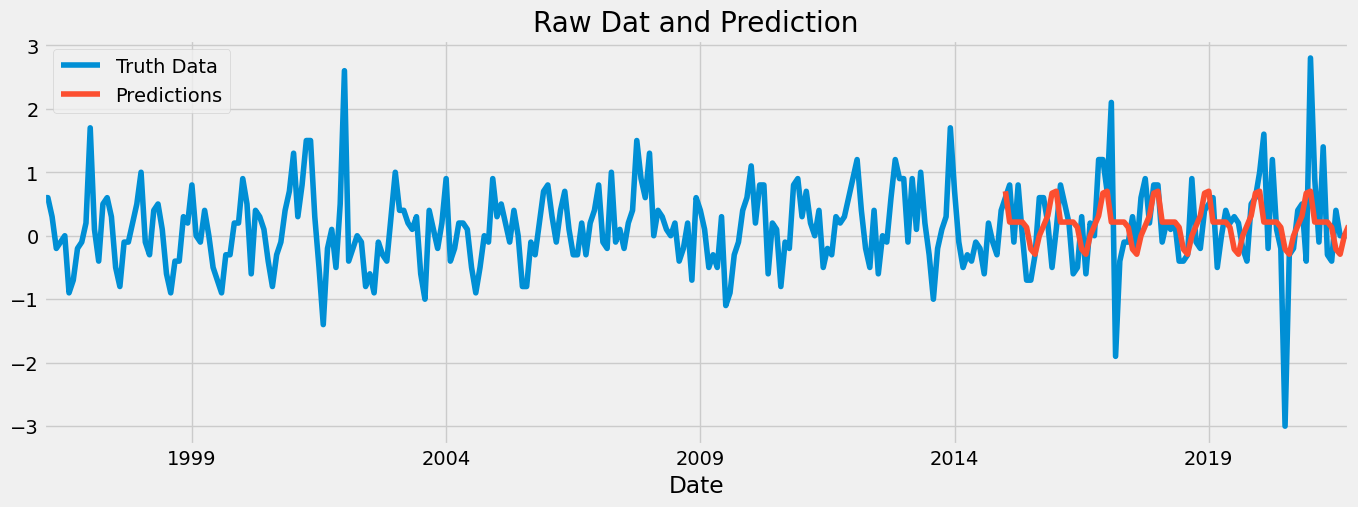

In [52]:
pipe4 = Pipeline([
    ("9", TrainModel(tss,split_time,use_cv, show_plot=True))  #start training including the cross validation and plot (optional)
])

df= pipe4.fit_transform(df)

### Get the Date of the start of the test data

In [24]:
df

,FoodPriceIndex,Month,Year,Quarter,prediction
Date,,,,,
1996-02-01,0.6,2,1996,1,NaN
1996-03-01,0.6,3,1996,1,NaN
1996-04-01,0.3,4,1996,2,NaN
1996-05-01,-0.2,5,1996,2,NaN
1996-06-01,-0.1,6,1996,2,NaN
...,...,...,...,...,...
2021-06-01,-0.4,6,2021,2,0.131782
2021-07-01,0.4,7,2021,3,-0.212067
2021-08-01,0.0,8,2021,3,-0.291363


In [25]:
row_ind, col_ind = np.where(df.isna())          #training ends where last value of prediction is NaN
start_of_test = np.max(row_ind) + 1
Year = df.iloc[start_of_test].Year
Month = df.iloc[start_of_test].Month
if Month < 10:
    start_time = f'{str(int(Year))}-0{str(int(Month))}'
else:
    start_time = f'{str(int(Year))}-{str(int(Month))}'

### Show Results (plot absolute data comparison and print mape and mspe)

In [26]:
df_debug = df

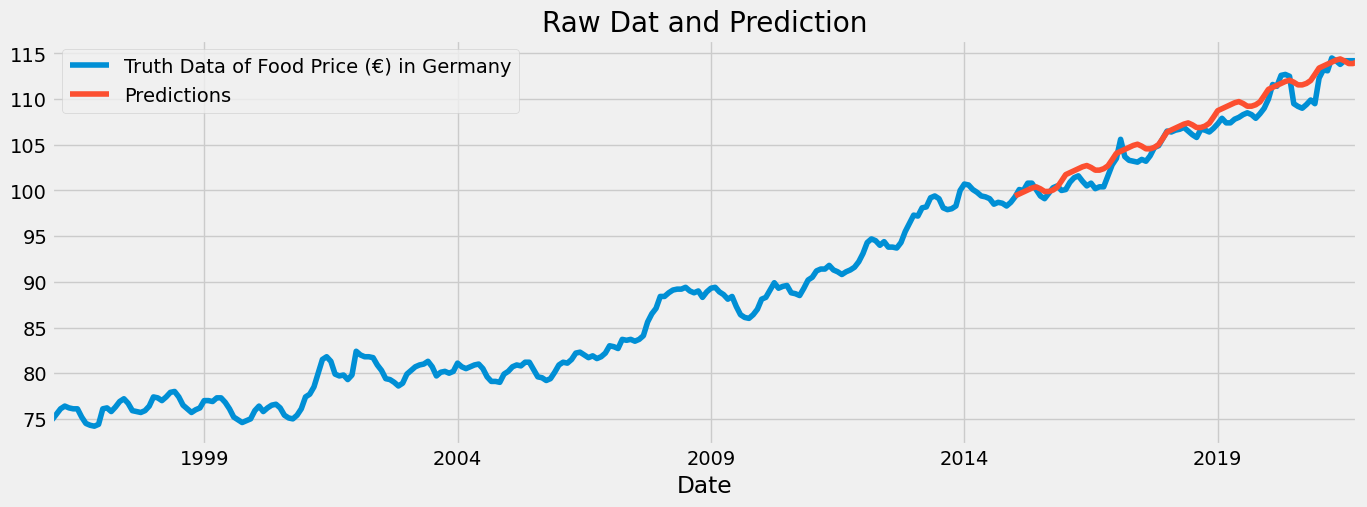

mean absolute percentage error: 0.009331482055076369, mean squared percentage error: 0.00013358926889714065


c:\Users\Jakob\Documents\git\Food-price-forecast\venv\Lib\site-packages\sktime\performance_metrics\forecasting\_classes.py:466: UserWarning: y_pred and y_true do not have the same column index. This may indicate incorrect objects passed to the metric. Indices of y_true will be used for y_pred.
  warn(
c:\Users\Jakob\Documents\git\Food-price-forecast\venv\Lib\site-packages\sktime\performance_metrics\forecasting\_classes.py:466: UserWarning: y_pred and y_true do not have the same column index. This may indicate incorrect objects passed to the metric. Indices of y_true will be used for y_pred.
  warn(


In [53]:
pipe5 = Pipeline([
    ("10", ShowResults(df_abs,start_time))  #start training including the cross validation and plot (optional)
])

df,res_mape,res_mspe = pipe5.fit_transform(df)

print(f'mean absolute percentage error: {res_mape}, mean squared percentage error: {res_mspe}')